For dataset 1  
The resnet-50 with the arcface

In [ ]:
#!/usr/bin/env python3
"""
train_arcface_finetune_true.py
True ArcFace fine-tuning with ResNet50 backbone,
Top-1 and Top-5 metrics, and plotted training curves.
"""
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# ==============================
# USER CONFIG
# ==============================
OUTPUT_DIR = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs"
train_dir  = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_1\train"
val_dir    = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_1\val"

PK_P, PK_K = 16, 4
IMG_SIZE   = (224, 224)
BATCH_SIZE = PK_P * PK_K

# ==============================
# Dataset
# ==============================

def preprocess_rgb(x, y):
    # convert grayscale -> RGB if needed
    x = tf.image.grayscale_to_rgb(x) if x.shape[-1] == 1 else x
    return x, y

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True,
    color_mode='rgb'  # <-- ensure it's loaded as 3-channel
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False,
    color_mode='rgb'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} unique classes.")


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess_rgb).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess_rgb).prefetch(AUTOTUNE)

train_ds = train_ds.map(lambda x, y: ((x, y), y))
val_ds   = val_ds.map(lambda x, y: ((x, y), y))

# ==============================
# 🧠 Custom ArcFace Layer
# ==============================
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.35, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[-1]), self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_theta = tf.matmul(x, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        theta = tf.acos(cos_theta)
        selected = tf.gather_nd(theta, tf.stack([tf.range(tf.shape(labels)[0]), labels], axis=1))
        theta_y_m = selected + self.m
        mask = tf.one_hot(labels, depth=self.num_classes)
        cos_theta_m = tf.cos(theta_y_m)
        logits = cos_theta * (1 - mask) + cos_theta_m[:, None] * mask
        logits *= self.s
        return logits

# ==============================
# Build True ArcFace Model
# ==============================
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    pooling='avg', input_shape=IMG_SIZE + (3,))
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
labels = tf.keras.Input(shape=(), dtype=tf.int32)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(512, activation=None,kernel_regularizer=tf.keras.regularizers.l2(1e-4), name="embedding")(x)
x = tf.keras.layers.BatchNormalization()(x)
logits = ArcFace(num_classes)(x, labels)
model = tf.keras.Model(inputs=[inputs, labels], outputs=logits, name="arcface_resnet50")

# ==============================
# Callbacks
# ==============================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, "1_best_arcface_model.keras"),
        monitor="val_top1_acc", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_top1_acc", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_top1_acc", patience=6, restore_best_weights=True, verbose=1)
]


# ==============================================
# 🧱 STAGE 1 — Freeze backbone (stabilize ArcFace head)
# ==============================================

initial_lr = 2e-4
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(initial_lr),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)


# ==============================
# Train
# ==============================
EPOCHS_1 = 15
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_1, callbacks=callbacks
)



# ==============================================
# 🔓 STAGE 2 — Unfreeze backbone (fine-tune entire model)
# ==============================================

print("\n🔓 Stage 2: Unfreezing backbone and fine-tuning entire model...")
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)

EPOCHS_2 = 15
total_epochs = EPOCHS_1 + EPOCHS_2

history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=EPOCHS_1,
    callbacks=callbacks
)

# Combine histories for full plot
def merge_histories(h1, h2):
    hist = {}
    for k in h1.history.keys():
        hist[k] = h1.history[k] + h2.history[k]
    return hist

full_history = merge_histories(history1, history2)



# ==============================
# Plot training graphs
# ==============================
def plot_history(history_dict, out_dir):
    epochs = np.arange(1, len(history_dict['loss']) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history_dict['loss'], label='train_loss')
    plt.plot(epochs, history_dict['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, history_dict['top1_acc'], label='train_top1')
    plt.plot(epochs, history_dict['val_top1_acc'], label='val_top1')
    plt.plot(epochs, history_dict['top5_acc'], label='train_top5', linestyle='--')
    plt.plot(epochs, history_dict['val_top5_acc'], label='val_top5', linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(out_dir, "1_training_history.png")
    plt.savefig(plot_path, dpi=200)
    plt.close()
    print(f"[save] training plot: {plot_path}")

plot_history(full_history, OUTPUT_DIR)

print("\n✅ Training completed. Best model saved as '1_best_arcface_model.keras'.")
print(f"Training history plot saved to: {os.path.join(OUTPUT_DIR, '1_training_history.png')}")


Found 4606 files belonging to 455 classes.
Found 550 files belonging to 455 classes.
Found 455 unique classes.
Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 16.4447 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00
Epoch 1: val_top1_acc improved from None to 0.00000, saving model to C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\1_best_arcface_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - loss: 15.7387 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00 - val_loss: 14.4508 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 13.1278 - top1_acc: 4.2885e-05 - top5_acc: 4.2885e-05
Epoch 2: val_top1_acc did not improve from 0.00000
72/72 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - loss: 12.7459 - top1_acc: 2.1711e-04 - top5_acc: 2.1711e-04 - val_loss: 11.9996 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0055 - learning_rate: 2.0000e-04
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/

KeyError: 'train_loss'

On dataset 1  
with some modification on the first one  
1. added on the fly augmentation
2. added the dropout
3. Unfrezee only the last 50 layer not the whole resnet 

In [ ]:
#!/usr/bin/env python3
"""
train_arcface_finetune_true.py
True ArcFace fine-tuning with ResNet50 backbone,
Top-1 and Top-5 metrics, and plotted training curves.
"""
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers


# ==============================
# USER CONFIG
# ==============================
OUTPUT_DIR = r"/content/drive/MyDrive/Colab Notebooks/arcface_runs"
train_dir  = r"/content/drive/MyDrive/Colab Notebooks/preprocess_dataset_1/train"
val_dir    = r"/content/drive/MyDrive/Colab Notebooks/preprocess_dataset_1/val"

PK_P, PK_K = 16, 4
IMG_SIZE   = (224, 224)
BATCH_SIZE = PK_P * PK_K

# ==============================
# Dataset
# ==============================
train_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.1)
])


def preprocess_rgb(x, y):
    # convert grayscale -> RGB if needed
    x = tf.image.grayscale_to_rgb(x) if x.shape[-1] == 1 else x
    return x, y

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True,
    color_mode='rgb'  # <-- ensure it's loaded as 3-channel
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False,
    color_mode='rgb'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} unique classes.")


AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    train_ds
    .map(preprocess_rgb)
    .map(lambda x, y: (train_augment(x, training=True), y))
    .map(lambda x, y: ((x, y), y))
    .prefetch(AUTOTUNE)   # ✅ at the END
)

val_ds = (
    val_ds
    .map(preprocess_rgb)
    .map(lambda x, y: ((x, y), y))
    .prefetch(AUTOTUNE)   # ✅ at the END
)

# ==============================
# 🧠 Custom ArcFace Layer
# ==============================
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.35, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[-1]), self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_theta = tf.matmul(x, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        theta = tf.acos(cos_theta)
        selected = tf.gather_nd(theta, tf.stack([tf.range(tf.shape(labels)[0]), labels], axis=1))
        theta_y_m = selected + self.m
        mask = tf.one_hot(labels, depth=self.num_classes)
        cos_theta_m = tf.cos(theta_y_m)
        logits = cos_theta * (1 - mask) + cos_theta_m[:, None] * mask
        logits *= self.s
        return logits

# ==============================
# Build True ArcFace Model
# ==============================
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    pooling='avg', input_shape=IMG_SIZE + (3,))
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
labels = tf.keras.Input(shape=(), dtype=tf.int32)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(512, activation=None,kernel_regularizer=tf.keras.regularizers.l2(1e-4), name="embedding")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
logits = ArcFace(num_classes)(x, labels)
model = tf.keras.Model(inputs=[inputs, labels], outputs=logits, name="arcface_resnet50")

# ==============================
# Callbacks
# ==============================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, "1.2_aug_best_arcface_model.keras"),
        monitor="val_top1_acc", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_top1_acc", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_top1_acc", patience=6, restore_best_weights=True, verbose=1)
]


# ==============================================
# 🧱 STAGE 1 — Freeze backbone (stabilize ArcFace head)
# ==============================================

initial_lr = 2e-4
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(initial_lr),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)


# ==============================
# Train
# ==============================
EPOCHS_1 = 15
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_1, callbacks=callbacks
)



# ==============================================
# 🔓 STAGE 2 — Unfreeze backbone (fine-tune entire model)
# ==============================================

print("\n🔓 Stage 2: Unfreezing backbone and fine-tuning entire model...")
N_UNFREEZE = 50  # try 30–70 depending on dataset size

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last N layers (but skip BN layers)
for layer in base_model.layers[-N_UNFREEZE:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# 🔒 Keep all BatchNorm layers frozen globally
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)

EPOCHS_2 = 25
total_epochs = EPOCHS_1 + EPOCHS_2

history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=EPOCHS_1,
    callbacks=callbacks
)

# Combine histories for full plot
def merge_histories(h1, h2):
    # handle both Keras History objects and dicts
    h1 = h1.history if hasattr(h1, "history") else h1
    h2 = h2.history if hasattr(h2, "history") else h2

    hist = {}
    for k in h1.keys():
        hist[k] = h1[k] + h2[k]
    return hist

full_history = merge_histories(history1, history2)



# ==============================
# Plot training graphs
# ==============================
def plot_history(history_dict, out_dir):
    epochs = np.arange(1, len(history_dict['loss']) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history_dict['loss'], label='train_loss')
    plt.plot(epochs, history_dict['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, history_dict['top1_acc'], label='train_top1')
    plt.plot(epochs, history_dict['val_top1_acc'], label='val_top1')
    plt.plot(epochs, history_dict['top5_acc'], label='train_top5', linestyle='--')
    plt.plot(epochs, history_dict['val_top5_acc'], label='val_top5', linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(out_dir, "1.2_aug_training_history.png")
    plt.savefig(plot_path, dpi=200)
    plt.close()
    print(f"[save] training plot: {plot_path}")

plot_history(full_history, OUTPUT_DIR)

print("\n✅ Training completed. Best model saved as '1.2_aug_best_arcface_model.keras'.")
print(f"Training history plot saved to: {os.path.join(OUTPUT_DIR, '1.2_aug_training_history.png')}")


Testing the model with the test dataset and plotting the roc curve

Found 550 files belonging to 455 classes.
[INFO] Loading trained ArcFace model from: C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\1.2_aug_best_arcface_model.keras


c:\Users\Amrit Shah\Desktop\Muzzle based Identification\env\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\Amrit Shah\Desktop\Muzzle based Identification\env\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
c:\Users\Amrit Shah\Desktop\Muzzle based Identification\env\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\Amr


📊 Evaluation Results:
   ➤ Top-1 Accuracy       : 86.55%
   ➤ Top-5 Accuracy       : 93.82%
   ➤ Balanced Accuracy    : 84.54%
   ➤ Macro F1-Score       : 0.8130
   ➤ Equal Error Rate (EER): 0.0397
   ➤ ROC-AUC (macro)      : 0.9880


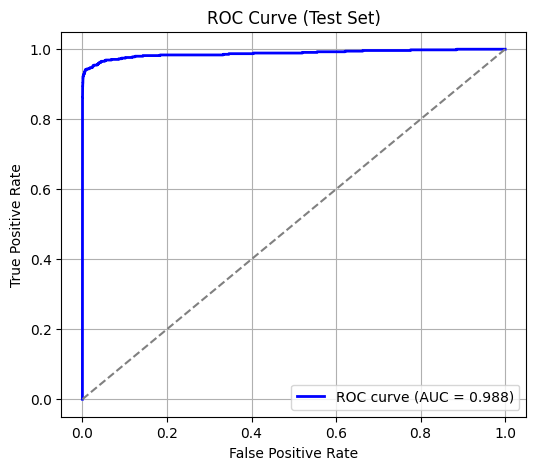


[INFO] Running t-SNE and UMAP visualization...
[WARN] UMAP not installed — skipping UMAP visualization.


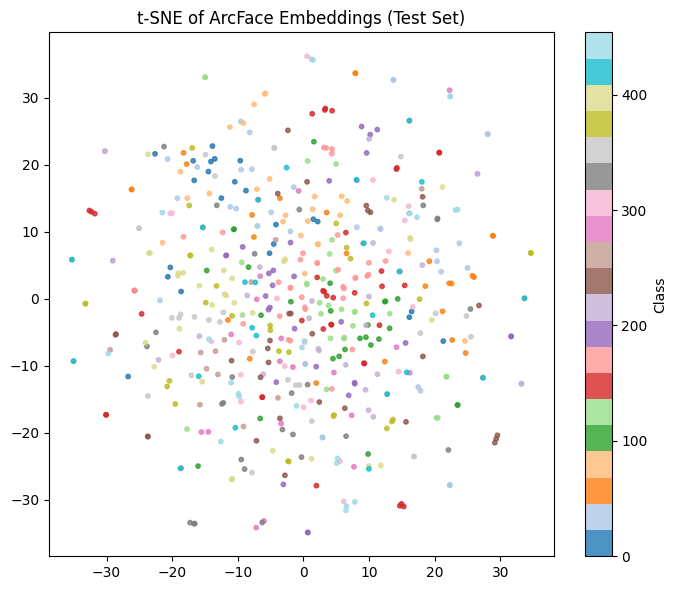

In [21]:
#!/usr/bin/env python3
"""
evaluate_arcface_metrics.py
Loads ArcFace-trained model, extracts embeddings,
and computes Top-K, ROC, EER, Balanced Accuracy, F1, and Recall on TEST dataset.
"""

import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score, recall_score
import matplotlib.pyplot as plt

# ==============================
# USER CONFIG
# ==============================
MODEL_PATH = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\1.2_aug_best_arcface_model.keras"
test_dir   = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_1\test"
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

# ==============================
# Load dataset
# ==============================
def preprocess_rgb(x, y):
    x = tf.image.grayscale_to_rgb(x) if x.shape[-1] == 1 else x
    return x, y

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, color_mode='rgb'
)
class_names = test_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.map(preprocess_rgb).prefetch(AUTOTUNE)

# ==============================
# Load full ArcFace model
# ==============================
print(f"[INFO] Loading trained ArcFace model from: {MODEL_PATH}")
# ==============================
# 🧠 ArcFace layer (same as training)
# ==============================
import tensorflow as tf

class ArcFace(tf.keras.layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.5, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[-1]), self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_theta = tf.matmul(x, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        theta = tf.acos(cos_theta)
        selected = tf.gather_nd(theta, tf.stack([tf.range(tf.shape(labels)[0]), labels], axis=1))
        theta_y_m = selected + self.m
        mask = tf.one_hot(labels, depth=self.num_classes)
        cos_theta_m = tf.cos(theta_y_m)
        logits = cos_theta * (1 - mask) + cos_theta_m[:, None] * mask
        logits *= self.s
        return logits
 # import your ArcFace layer definition
full_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"ArcFace": ArcFace})

# ==============================
# Build inference (embedding) model
# ==============================
from tensorflow.keras.models import Model

# Full loaded model
full_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"ArcFace": ArcFace})

# Build embedding model: input = image, output = batch normalization (embedding)
embedding_model = Model(
    inputs=full_model.input[0],                        # image input only
    outputs=full_model.get_layer("batch_normalization").output
)


# ==============================
# Get predictions
# ==============================
y_true = []
embeddings = []
for batch_x, batch_y in test_ds:
    emb = embedding_model(batch_x, training=False)
    embeddings.append(emb.numpy())
    y_true.append(batch_y.numpy())

embeddings = np.concatenate(embeddings)
y_true = np.concatenate(y_true)

# Compute cosine similarities as logits (simple classification)
W = full_model.get_layer("arc_face").W.numpy()  # ArcFace class weights
W = W / np.linalg.norm(W, axis=0, keepdims=True)
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
logits = np.dot(emb_norm, W)

y_pred = np.argmax(logits, axis=1)
y_score = tf.nn.softmax(logits, axis=1).numpy()

# ==============================
# Compute metrics
# ==============================
# Top-1 & Top-5
top1 = np.mean(np.equal(y_true, np.argmax(y_score, axis=1)))
top5 = np.mean([y_true[i] in np.argsort(y_score[i])[-5:] for i in range(len(y_true))])

# ROC & AUC (macro average)
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true, num_classes).ravel(),
                        y_score.ravel())
roc_auc = auc(fpr, tpr)

# EER
fnr = 1 - tpr
eer_threshold = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

# Other metrics
bal_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average=None)

# ==============================
# Print metrics
# ==============================
print("\n📊 Evaluation Results:")
print(f"   ➤ Top-1 Accuracy       : {top1*100:.2f}%")
print(f"   ➤ Top-5 Accuracy       : {top5*100:.2f}%")
print(f"   ➤ Balanced Accuracy    : {bal_acc*100:.2f}%")
print(f"   ➤ Macro F1-Score       : {f1:.4f}")
print(f"   ➤ Equal Error Rate (EER): {eer:.4f}")
print(f"   ➤ ROC-AUC (macro)      : {roc_auc:.4f}")

# ==============================
# Plot ROC Curve
# ==============================
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n[INFO] Running t-SNE and UMAP visualization...")

from sklearn.manifold import TSNE
try:
    from umap import UMAP
    has_umap = True
except ImportError:
    print("[WARN] UMAP not installed — skipping UMAP visualization.")
    has_umap = False

# ---- t-SNE ----
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=30)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=y_true, cmap='tab20', s=10, alpha=0.8)
plt.title("t-SNE of ArcFace Embeddings (Test Set)")
plt.colorbar(scatter, label="Class")
plt.tight_layout()
plt.show()

# ---- UMAP ----
if has_umap:
    reducer = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    emb_umap = reducer.fit_transform(embeddings)

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(emb_umap[:,0], emb_umap[:,1], c=y_true, cmap='tab20', s=10, alpha=0.8)
    plt.title("UMAP of ArcFace Embeddings (Test Set)")
    plt.colorbar(scatter, label="Class")
    plt.tight_layout()
    plt.show()
    


For the dataset set 2  
Used the arcface with the resnet-50 to train the model

In [28]:
#!/usr/bin/env python3
"""
train_arcface_finetune_true.py
True ArcFace fine-tuning with ResNet50 backbone,
Top-1 and Top-5 metrics, and plotted training curves.
"""
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# ==============================
# USER CONFIG
# ==============================
OUTPUT_DIR = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs"
train_dir  = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_2\train"
val_dir    = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_2\val"

PK_P, PK_K = 8, 4
IMG_SIZE   = (224, 224)
BATCH_SIZE = PK_P * PK_K

# ==============================
# Dataset
# ==============================
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} unique classes.")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# Map for ArcFace inputs ((x,y), y)
train_ds = train_ds.map(lambda x, y: ((x, y), y))
val_ds   = val_ds.map(lambda x, y: ((x, y), y))

# ==============================
# 🧠 Custom ArcFace Layer
# ==============================
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.5, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[-1]), self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_theta = tf.matmul(x, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        theta = tf.acos(cos_theta)
        selected = tf.gather_nd(theta, tf.stack([tf.range(tf.shape(labels)[0]), labels], axis=1))
        theta_y_m = selected + self.m
        mask = tf.one_hot(labels, depth=self.num_classes)
        cos_theta_m = tf.cos(theta_y_m)
        logits = cos_theta * (1 - mask) + cos_theta_m[:, None] * mask
        logits *= self.s
        return logits

# ==============================
# Build True ArcFace Model
# ==============================
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    pooling='avg', input_shape=IMG_SIZE + (3,))
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
labels = tf.keras.Input(shape=(), dtype=tf.int32)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(512, activation=None, name="embedding")(x)
x = tf.keras.layers.BatchNormalization()(x)
logits = ArcFace(num_classes)(x, labels)
model = tf.keras.Model(inputs=[inputs, labels], outputs=logits, name="arcface_resnet50")

# ==============================
# Compile
# ==============================
initial_lr = 1e-4
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(initial_lr),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)

# ==============================
# Callbacks
# ==============================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, "best_arcface_model.keras"),
        monitor="val_top1_acc", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_top1_acc", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_top1_acc", patience=6, restore_best_weights=True, verbose=1)
]

# ==============================
# Train
# ==============================
EPOCHS = 30
history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS, callbacks=callbacks
)

# ==============================
# Plot training graphs
# ==============================
def plot_history(history_dict, out_dir):
    epochs = np.arange(1, len(history_dict['loss']) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history_dict['loss'], label='train_loss')
    plt.plot(epochs, history_dict['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, history_dict['top1_acc'], label='train_top1')
    plt.plot(epochs, history_dict['val_top1_acc'], label='val_top1')
    plt.plot(epochs, history_dict['top5_acc'], label='train_top5', linestyle='--')
    plt.plot(epochs, history_dict['val_top5_acc'], label='val_top5', linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(out_dir, "training_history.png")
    plt.savefig(plot_path, dpi=200)
    plt.close()
    print(f"[save] training plot: {plot_path}")

plot_history(history.history, OUTPUT_DIR)

print("\n✅ Training completed. Best model saved as 'best_arcface_model.keras'.")
print(f"Training history plot saved to: {os.path.join(OUTPUT_DIR, 'training_history.png')}")


Found 3725 files belonging to 268 classes.
Found 623 files belonging to 268 classes.
Found 268 unique classes.
Epoch 1/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 19.4634 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00
Epoch 1: val_top1_acc improved from None to 0.00000, saving model to C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\best_arcface_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - loss: 18.2777 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00 - val_loss: 16.4305 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 14.9473 - top1_acc: 1.1778e-04 - top5_acc: 6.2181e-04
Epoch 2: val_top1_acc improved from 0.00000 to 0.01445, saving model to C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\best_arcface_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - loss: 14.1781 - top1_acc: 0.0021 - top5_acc: 0.0048 - val_loss: 12.3042 - val_

Some modification for the dataset 2, where i have addes the augmentation while training, added the dropout, unfrezee the resnet-50 last 50 layers for fine tunning

In [13]:
#!/usr/bin/env python3
"""
train_arcface_finetune_true.py
True ArcFace fine-tuning with ResNet50 backbone,
Top-1 and Top-5 metrics, and plotted training curves.
"""
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers

# ==============================
# USER CONFIG
# ==============================
OUTPUT_DIR = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs"
train_dir  = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_2\train"
val_dir    = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_2\val"

PK_P, PK_K = 16, 4
IMG_SIZE   = (224, 224)
BATCH_SIZE = PK_P * PK_K

# ==============================
# Dataset
# ==============================
train_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.1)
])


def preprocess_rgb(x, y):
    # convert grayscale -> RGB if needed
    x = tf.image.grayscale_to_rgb(x) if x.shape[-1] == 1 else x
    return x, y

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True,
    color_mode='rgb'  # <-- ensure it's loaded as 3-channel
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='int',
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False,
    color_mode='rgb'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} unique classes.")


AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    train_ds
    .map(preprocess_rgb)
    .map(lambda x, y: (train_augment(x, training=True), y))
    .map(lambda x, y: ((x, y), y))
    .prefetch(AUTOTUNE)   # ✅ at the END
)

val_ds = (
    val_ds
    .map(preprocess_rgb)
    .map(lambda x, y: ((x, y), y))
    .prefetch(AUTOTUNE)   # ✅ at the END
)

# ==============================
# 🧠 Custom ArcFace Layer
# ==============================
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.5, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[-1]), self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_theta = tf.matmul(x, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        theta = tf.acos(cos_theta)
        selected = tf.gather_nd(theta, tf.stack([tf.range(tf.shape(labels)[0]), labels], axis=1))
        theta_y_m = selected + self.m
        mask = tf.one_hot(labels, depth=self.num_classes)
        cos_theta_m = tf.cos(theta_y_m)
        logits = cos_theta * (1 - mask) + cos_theta_m[:, None] * mask
        logits *= self.s
        return logits


# ==============================
# Build True ArcFace Model
# ==============================
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    pooling='avg', input_shape=IMG_SIZE + (3,))
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
labels = tf.keras.Input(shape=(), dtype=tf.int32)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dense(512, activation=None,kernel_regularizer=tf.keras.regularizers.l2(1e-4), name="embedding")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
logits = ArcFace(num_classes)(x, labels)
model = tf.keras.Model(inputs=[inputs, labels], outputs=logits, name="arcface_resnet50")

# ==============================
# Callbacks
# ==============================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, "2.1_best_arcface_model.keras"),
        monitor="val_top1_acc", save_best_only=True, mode="max", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_top1_acc", factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_top1_acc", patience=6, restore_best_weights=True, verbose=1)
]


# ==============================================
# 🧱 STAGE 1 — Freeze backbone (stabilize ArcFace head)
# ==============================================

initial_lr = 2e-4
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(initial_lr),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)


# ==============================
# Train
# ==============================
EPOCHS_1 = 15
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_1, callbacks=callbacks
)



# ==============================================
# 🔓 STAGE 2 — Unfreeze backbone (fine-tune entire model)
# ==============================================

print("\n🔓 Stage 2: Unfreezing backbone and fine-tuning entire model...")
N_UNFREEZE = 50  # try 30–70 depending on dataset size

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last N layers (but skip BN layers)
for layer in base_model.layers[-N_UNFREEZE:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# 🔒 Keep all BatchNorm layers frozen globally
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top1_acc"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5_acc")
    ]
)

EPOCHS_2 = 25
total_epochs = EPOCHS_1 + EPOCHS_2

history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=EPOCHS_1,
    callbacks=callbacks
)


# Combine histories for full plot
def merge_histories(h1, h2):
    # handle both Keras History objects and dicts
    h1 = h1.history if hasattr(h1, "history") else h1
    h2 = h2.history if hasattr(h2, "history") else h2

    hist = {}
    for k in h1.keys():
        hist[k] = h1[k] + h2[k]
    return hist

full_history = merge_histories(history1, history2)



# ==============================
# Plot training graphs
# ==============================
def plot_history(history_dict, out_dir):
    epochs = np.arange(1, len(history_dict['loss']) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history_dict['loss'], label='train_loss')
    plt.plot(epochs, history_dict['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(epochs, history_dict['top1_acc'], label='train_top1')
    plt.plot(epochs, history_dict['val_top1_acc'], label='val_top1')
    plt.plot(epochs, history_dict['top5_acc'], label='train_top5', linestyle='--')
    plt.plot(epochs, history_dict['val_top5_acc'], label='val_top5', linestyle='--')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(out_dir, "2.1_training_history.png")
    plt.savefig(plot_path, dpi=200)
    plt.close()
    print(f"[save] training plot: {plot_path}")

plot_history(full_history, OUTPUT_DIR)

print("\n✅ Training completed. Best model saved as '2.1_best_arcface_model.keras'.")
print(f"Training history plot saved to: {os.path.join(OUTPUT_DIR, '2.1_training_history.png')}")


Found 3725 files belonging to 268 classes.
Found 623 files belonging to 268 classes.
Found 268 unique classes.
Epoch 1/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 19.8339 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00
Epoch 1: val_top1_acc improved from None to 0.00000, saving model to C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\2.1_best_arcface_model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 389s 6s/step - loss: 18.9550 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00 - val_loss: 17.6285 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 2/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 16.4309 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00
Epoch 2: val_top1_acc did not improve from 0.00000
59/59 ━━━━━━━━━━━━━━━━━━━━ 345s 6s/step - loss: 15.8630 - top1_acc: 0.0000e+00 - top5_acc: 0.0000e+00 - val_loss: 14.7663 - val_top1_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00 - learning_rate: 2.0000e-04
Epoch 3/15
59/59 ━━━━━━━━━━━━━━━━━━━━ 

Testing the trained model and evaluating the top 1 and top 5 accuracy, ROC, EER, Recall , balanced accuracy and plotting the t-SNE

Found 972 files belonging to 268 classes.
[INFO] Found 268 test classes.
[INFO] Loading model from: C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\2.1_best_arcface_model.keras
[INFO] Model loaded successfully.
[INFO] Embedding model built successfully.
[INFO] Extracted embeddings shape: (972, 512)

📊 Evaluation Results on Test Set:
   ➤ Top-1 Accuracy       : 98.56%
   ➤ Top-5 Accuracy       : 99.69%
   ➤ Balanced Accuracy    : 98.03%
   ➤ Macro F1-Score       : 0.9788
   ➤ Macro Recall         : 0.9803
   ➤ ROC-AUC (macro)      : 0.9998
   ➤ Equal Error Rate (EER): 0.0028


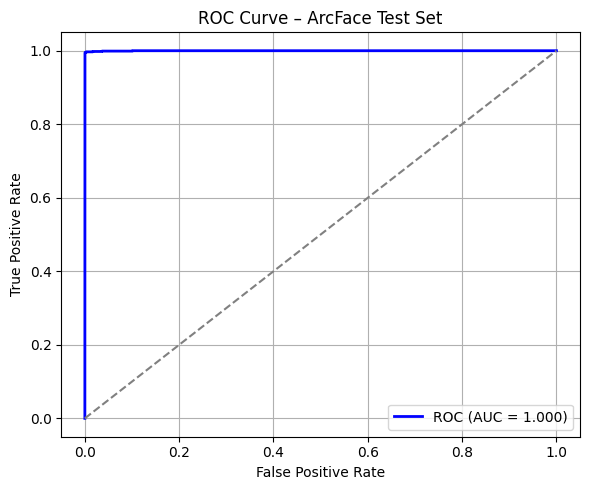


[INFO] Running t-SNE and UMAP visualization...
[WARN] UMAP not installed — skipping UMAP visualization.


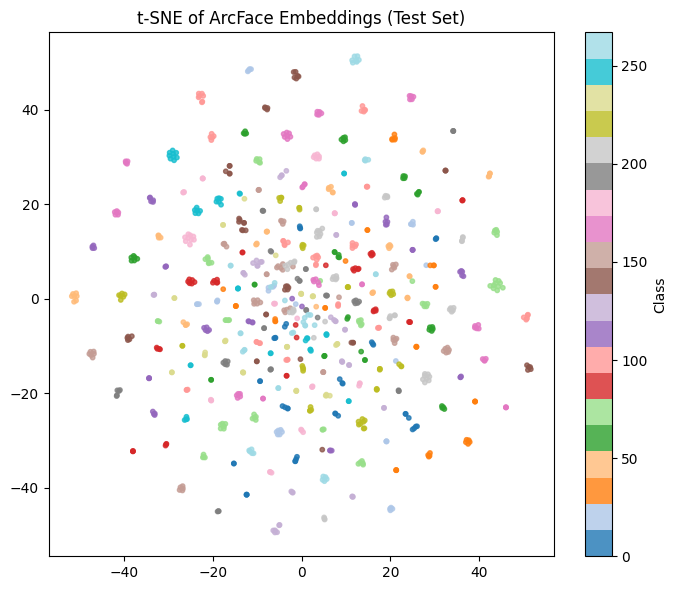

[SAVE] t-SNE plot saved to: C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\2.1_tsne_embeddings.png


In [ ]:
#!/usr/bin/env python3
"""
evaluate_arcface_metrics_with_tsne_umap.py
Evaluates ArcFace + ResNet50 model and visualizes embeddings using t-SNE and UMAP.
"""

import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score, recall_score
import matplotlib.pyplot as plt

# ======================================================
# USER CONFIG
# ======================================================
MODEL_PATH = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\arcface_runs\2.1_best_arcface_model.keras"
TEST_DIR   = r"C:\Users\Amrit Shah\Desktop\Muzzle based Identification\DL\preprocess_dataset_2\test"
OUTPUT_DIR = os.path.dirname(MODEL_PATH)
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

# ======================================================
# Dataset
# ======================================================
def preprocess_rgb(x, y):
    x = tf.image.grayscale_to_rgb(x) if x.shape[-1] == 1 else x
    return x, y

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='rgb'
)
class_names = test_ds.class_names
num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.map(preprocess_rgb).prefetch(AUTOTUNE)

print(f"[INFO] Found {num_classes} test classes.")

# ======================================================
# ArcFace Layer Definition (same as training)
# ======================================================
class ArcFace(tf.keras.layers.Layer):
    def __init__(self, num_classes, s=30.0, m=0.5, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[-1]), self.num_classes),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        cos_theta = tf.matmul(x, W)
        cos_theta = tf.clip_by_value(cos_theta, -1.0, 1.0)
        theta = tf.acos(cos_theta)
        selected = tf.gather_nd(theta, tf.stack([tf.range(tf.shape(labels)[0]), labels], axis=1))
        theta_y_m = selected + self.m
        mask = tf.one_hot(labels, depth=self.num_classes)
        cos_theta_m = tf.cos(theta_y_m)
        logits = cos_theta * (1 - mask) + cos_theta_m[:, None] * mask
        logits *= self.s
        return logits

# ======================================================
# Load trained ArcFace model
# ======================================================
print(f"[INFO] Loading model from: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={"ArcFace": ArcFace})
print("[INFO] Model loaded successfully.")

# ======================================================
# Build embedding extractor
# ======================================================
image_input = tf.keras.Input(shape=IMG_SIZE + (3,), name="image_input")
base_model = model.get_layer("resnet50")
x = tf.keras.applications.resnet50.preprocess_input(image_input)
x = base_model(x, training=False)
x = model.get_layer("embedding")(x)
x = model.get_layer("batch_normalization")(x)
embedding_model = tf.keras.Model(inputs=image_input, outputs=x, name="embedding_model")
print("[INFO] Embedding model built successfully.")

# ======================================================
# Compute embeddings for test set
# ======================================================
embeddings, y_true = [], []
for batch_x, batch_y in test_ds:
    emb = embedding_model(batch_x, training=False)
    embeddings.append(emb.numpy())
    y_true.append(batch_y.numpy())

embeddings = np.concatenate(embeddings)
y_true = np.concatenate(y_true)
print(f"[INFO] Extracted embeddings shape: {embeddings.shape}")

# ======================================================
# Compute class logits using ArcFace weights
# ======================================================
arc_layer = model.get_layer("arc_face")
W = arc_layer.W.numpy()
W = W / np.linalg.norm(W, axis=0, keepdims=True)
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
logits = np.dot(emb_norm, W)
y_score = tf.nn.softmax(logits, axis=1).numpy()
y_pred = np.argmax(y_score, axis=1)

# ======================================================
# Compute metrics
# ======================================================
top1 = np.mean(y_true == y_pred)
top5 = np.mean([y_true[i] in np.argsort(y_score[i])[-5:] for i in range(len(y_true))])

fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true, num_classes).ravel(),
                        y_score.ravel())
roc_auc = auc(fpr, tpr)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_idx]

bal_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print("\n📊 Evaluation Results on Test Set:")
print(f"   ➤ Top-1 Accuracy       : {top1*100:.2f}%")
print(f"   ➤ Top-5 Accuracy       : {top5*100:.2f}%")
print(f"   ➤ Balanced Accuracy    : {bal_acc*100:.2f}%")
print(f"   ➤ Macro F1-Score       : {f1:.4f}")
print(f"   ➤ Macro Recall         : {recall:.4f}")
print(f"   ➤ ROC-AUC (macro)      : {roc_auc:.4f}")
print(f"   ➤ Equal Error Rate (EER): {eer:.4f}")

# ======================================================
# Plot ROC curve
# ======================================================
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – ArcFace Test Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======================================================
# 🔍 Visualization: t-SNE and UMAP of embeddings
# ======================================================
print("\n[INFO] Running t-SNE and UMAP visualization...")

from sklearn.manifold import TSNE
try:
    from umap import UMAP
    has_umap = True
except ImportError:
    print("[WARN] UMAP not installed — skipping UMAP visualization.")
    has_umap = False

# ---- t-SNE ----
tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=30)
emb_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=y_true, cmap='tab20', s=10, alpha=0.8)
plt.title("t-SNE of ArcFace Embeddings (Test Set)")
plt.colorbar(scatter, label="Class")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "2.1_tsne_embeddings.png"), dpi=200)
plt.show()
print(f"[SAVE] t-SNE plot saved to: {os.path.join(OUTPUT_DIR, '2.1_tsne_embeddings.png')}")

# ---- UMAP ----
if has_umap:
    reducer = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    emb_umap = reducer.fit_transform(embeddings)

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(emb_umap[:,0], emb_umap[:,1], c=y_true, cmap='tab20', s=10, alpha=0.8)
    plt.title("UMAP of ArcFace Embeddings (Test Set)")
    plt.colorbar(scatter, label="Class")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "2.1_umap_embeddings.png"), dpi=200)
    plt.show()
    print(f"[SAVE] UMAP plot saved to: {os.path.join(OUTPUT_DIR, '2.1_umap_embeddings.png')}")
